# Setup

## Basic Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt #for displaying plots
import pandas as pd
import seaborn as sns
import tensorflow as tf

from keras.layers import *
from keras.models import Sequential
from keras.models import Model
from keras.optimizers import *
from keras.callbacks import *
from keras import regularizers
from keras.utils import plot_model

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.inspection import permutation_importance
import datetime
import random
import properscoring as ps

from scipy.stats import norm

import shap
import xgboost
import pydot
import graphviz
import os
from pathlib import Path

In [2]:
# setting a seed to ensure reproducability and consistency
random.seed(16)
np.random.seed(16)
tf.random.set_seed(16)

In [3]:
plt.rcParams.update({'font.size': 14})

In [4]:
# Change Working Directory
os.chdir("..")
print(os.getcwd()) # print current working directory

c:\Users\aisti\OneDrive\Dokumente\Uni\Bachelorarbeit\Probabilistic-Forecasting-of-Bicycle-Counts-in-Karlsruhe-with-Neural-Networks


In [5]:
X_train = pd.read_pickle(r"data\X_train.pkl")
X_valid = pd.read_pickle(r"data\X_valid.pkl")
X_test = pd.read_pickle(r"data\X_test.pkl")

X_train_num = pd.read_pickle(r"data\X_train_num.pkl")
X_valid_num = pd.read_pickle(r"data\X_valid_num.pkl")
X_test_num = pd.read_pickle(r"data\X_test_num.pkl")

y_train = pd.read_pickle(r"data\y_train.pkl")
y_valid = pd.read_pickle(r"data\y_valid.pkl")
y_test = pd.read_pickle(r"data\y_test.pkl")

In [6]:
X_train['date'] =  pd.to_datetime(X_train['date'])
X_valid['date'] =  pd.to_datetime(X_valid['date'])
X_test['date'] =  pd.to_datetime(X_test['date'])

In [8]:
base_path_plots = Path(r"Figures\(08) Permutation_Importance_and_SHAP_Testing")

# Functions

In [5]:
def crps_normal_cost_function(y_true, y_pred, tensor=True):
    """Compute the CRPS cost function for a normal distribution defined by
    the mean and standard deviation.

    Args:
        y_true: True values
        y_pred: Tensor containing predictions: [mean, std]

    Returns:
        mean_crps: Scalar with mean CRPS over batch or tensor with all crps values of batch
    """
    # get rid of axis 1
    if tensor:
        y_true = y_true[:, 0]
    
    # Split input
    mu = y_pred[:, 0]
    var = tf.square(y_pred[:, 1]) # Ensure standard deviation is positive
    sigma = tf.sqrt(var)  
    #sigma = y_pred[:, 1]

    # The following three variables are just for convenience
    loc = (y_true - mu) / sigma
    phi = 1.0 / tf.sqrt(2.0 * np.pi) * tf.exp(-tf.square(loc) / 2.0)
    Phi = 0.5 * (1.0 + tf.math.erf(loc / tf.sqrt(2.0)))
    # First we will compute the crps for each input/target pair
    crps =  sigma * (loc * (2. * Phi - 1.) + 2 * phi - 1. / tf.sqrt(np.pi))
    # Then we take the mean. The cost is now a scalar
    return tf.reduce_mean(crps) if tensor else crps

In [6]:
def crps_normal_cost_function_v2(y_true, y_pred, tensor=True):
    """Compute the CRPS cost function for a normal distribution defined by
    the mean and standard deviation.

    Args:
        y_true: True values
        y_pred: Tensor containing predictions: [mean, std]

    Returns:
        mean_crps: Scalar with mean CRPS over batch or tensor with all crps values of batch
    """
    # get rid of axis 1
    if tensor:
        y_true = y_true[:, 0]

    # Split input
    mu = y_pred[:, 0]
    sigma = tf.math.softplus(y_pred[:, 1])  # Apply softplus to ensure positive std
    #sigma = y_pred[:, 1]

    # The following three variables are just for convenience
    loc = (y_true - mu) / sigma
    phi = 1.0 / tf.sqrt(2.0 * np.pi) * tf.exp(-tf.square(loc) / 2.0)
    Phi = 0.5 * (1.0 + tf.math.erf(loc / tf.sqrt(2.0)))
    # First we will compute the crps for each input/target pair
    crps =  sigma * (loc * (2. * Phi - 1.) + 2 * phi - 1. / tf.sqrt(np.pi))
    
    # Then we take the mean. The cost is now a scalar
    return tf.reduce_mean(crps) if tensor else crps

In [7]:
def predict_and_calculate_mean_crps(model, X_test = X_test_num, y_test = y_test, print_predicted_mean_std = False):
    """Make predictions on test data and calculate mean CRPS.

    Args:
        model: Trained model
        X_test: Test data
        y_test: True values
        print_predicted_mean_std: Boolean to print predicted mean and std

    Returns:
        mean_crps: Scalar with mean CRPS over batch or tensor with all crps values of batch
    """
     
    predicted_mean_std = model.predict(X_test)
    if print_predicted_mean_std:
        print(predicted_mean_std)
    
    predicted_mean = predicted_mean_std[:, 0]
    predicted_std = predicted_mean_std[:, 1]
    mean_crps = np.mean(ps.crps_gaussian(y_test, mu=predicted_mean, sig=predicted_std))
    print(f"\nMean CRPS: { mean_crps }")


    return mean_crps, predicted_mean_std

In [8]:
def compile_and_fit_model(model, X_train = X_train_num, y_train = y_train, X_valid = X_valid_num, y_valid = y_valid,  pat=5, lr=1e-3, loss_function = crps_normal_cost_function, epochs = 100, batch_size = 10):
    """Compile and fit a model on training data.

    Args:
        model: model to be trained
        X_train: Training data
        y_train: Training targets
        X_valid: Validation data
        y_valid: Validation targets
        pat: Patience for early stopping
        lr: Learning rate
        loss_function: Loss function
        epochs: Number of epochs
        batch_size: Batch size

    Returns:
        model: Trained model
    """

    #print some information about the model
    print('Model information:\n\nCallbacks: EarlyStopping (patience: ' + str(pat) + '), Learning Rate (Reduce on Plateau, patience: ' + str(pat) + ')\nBatch size: ' + str(batch_size) + '\nEpochs: ' + str(epochs) + '\n')
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=pat, 
                                                      restore_best_weights=True)
    
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                     factor=0.2,
                                                     patience = pat,
                                                     min_lr=0 )
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=loss_function)

    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_valid, y_valid), callbacks=[early_stopping, reduce_lr])

    return model, history

In [9]:
def plot_loss(history):
    """Plot training and validation loss.

    Args:
        history: History object
    """
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [10]:
def process_model(model, X_train,  X_valid, X_test, y_train = y_train, y_valid = y_valid, y_test = y_test, pat=5, lr=1e-3, loss_function = crps_normal_cost_function, epochs = 100, batch_size = 10, print_predicted_mean_std = False, plot_loss_flag = True):
    """Compile, fit and evaluate a model.

    Args:
        model: model to be trained
        X_train: Training data
        y_train: Training targets
        X_valid: Validation data
        y_valid: Validation targets
        X_test: Test data
        y_test: Test targets
        pat: Patience for early stopping
        lr: Learning rate
        loss_function: Loss function
        epochs: Number of epochs
        batch_size: Batch size
        print_predicted_mean_std: Boolean to print predicted mean and std
"""

    model, history = compile_and_fit_model(model, X_train, y_train, X_valid, y_valid,  pat, lr, loss_function, epochs, batch_size)

    mean_crps, predicted_mean_std = predict_and_calculate_mean_crps(model, X_test, y_test, print_predicted_mean_std)

    if plot_loss_flag:
        plot_loss(history)

    return model, mean_crps, history, predicted_mean_std

In [11]:
def check_positive_std_devs(std_devs):
    """Check if all standard deviations are positive (since there might be errors in the model calculation).
    Args:
        std_devs: Standard deviations
    """
    
    # Check if any standard deviations are non-positive
    if np.any(std_devs <= 0):
        raise ValueError("All standard deviations must be positive and non-zero.")
    

In [12]:
def build_baseline_model(input_shape):
    model = Sequential([
    Dense(256, input_shape=(input_shape,), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(2, activation= 'softplus')  
    ])

    print("""
    Mean CRPS for baseline model with all predictors (except one-hot encoded holiday data): 329.4322340624611
    Columns in baseline model:
    'temperature', 'humidity', 'windspeed', 'wind_direction', 'visibility',
    'precipitation', 'sun', 'windspeed_max', 'precip_indic',
    'school_holiday_indicator', 'public_holiday_indicator',
    'holiday_indicator', 'is_workday', 'season', 'day_of_week'
    """)

    return model

# Feature Importance

In [13]:
def crps_scorer(estimator, X, y):
    """
    A wrapper for crps_normal_cost_function to work with Scikit-learn's scoring API.
    
    Args:
        estimator: Trained model with a `predict` method.
        X: Features (numpy array or pandas DataFrame).
        y: True target values (numpy array or pandas Series).

    Returns:
        Scalar score (negative CRPS for minimization).
    """
    # Generate predictions using the model
    y_pred = estimator.predict(X)  # Assuming [mean, std] output
    # Ensure y is a NumPy array
    y_true = y.to_numpy() if hasattr(y, "to_numpy") else y
    # Call the CRPS function (use tensor=False to avoid TensorFlow tensors)
    crps_values = crps_normal_cost_function(y_true, y_pred, tensor=False)
    # Return the mean CRPS as a negative value for minimization
    return -np.mean(crps_values)  # Negating for Scikit-learn's convention

In [14]:
X_test_num.columns

Index(['temperature', 'humidity', 'windspeed', 'wind_direction', 'visibility',
       'precipitation', 'sun', 'windspeed_max', 'precip_indic',
       'school_holiday_indicator', 'public_holiday_indicator',
       'holiday_indicator', 'is_workday', 'season', 'day_of_week'],
      dtype='object')

## Permutation Importance

Note: this code is not entirely correct, the correctly calculated permutation importance is in notebook 3

In [13]:
model9 = Sequential([
    Dense(256, input_shape=(X_train_num.shape[1],), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(2, activation= 'softplus')  
])

In [14]:
model9, mean_crps9, history9, predicted_means_std9 = process_model(model9, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num, loss_function=crps_normal_cost_function_v2) 

NameError: name 'process_model' is not defined

In [9]:
model11 = Sequential([
    Dense(256, input_shape=(X_train_num.shape[1],), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(2, activation= 'softplus')  
])

c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
model11a, mean_crps11, history11, predicted_means_std11 = process_model(model11, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num, epochs = 200)


NameError: name 'process_model' is not defined

In [ ]:
#permutation importance
result_model11a = permutation_importance(model11a, X_test_num, y_test, scoring=crps_scorer)
importances_model11a = result_model11a.importances_mean

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1

In [11]:
feature_names = X_test_num.columns

importance_df_model11a = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances_model11a
}).sort_values(by='Importance', ascending=False)

print(importance_df_model11a)

NameError: name 'importances_model11a' is not defined

In [12]:

# Plot feature importances
feature_importance_no_errors = plt.figure(figsize=(10, 6))
plt.barh(importance_df_model11a['Feature'], importance_df_model11a['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Highest importance on top
plt.show()
feature_importance_no_errors.figure.savefig(base_path_plots / "permutation_importance_model11a_no_errors.png")

NameError: name 'importance_df_model11a' is not defined

<Figure size 1000x600 with 0 Axes>

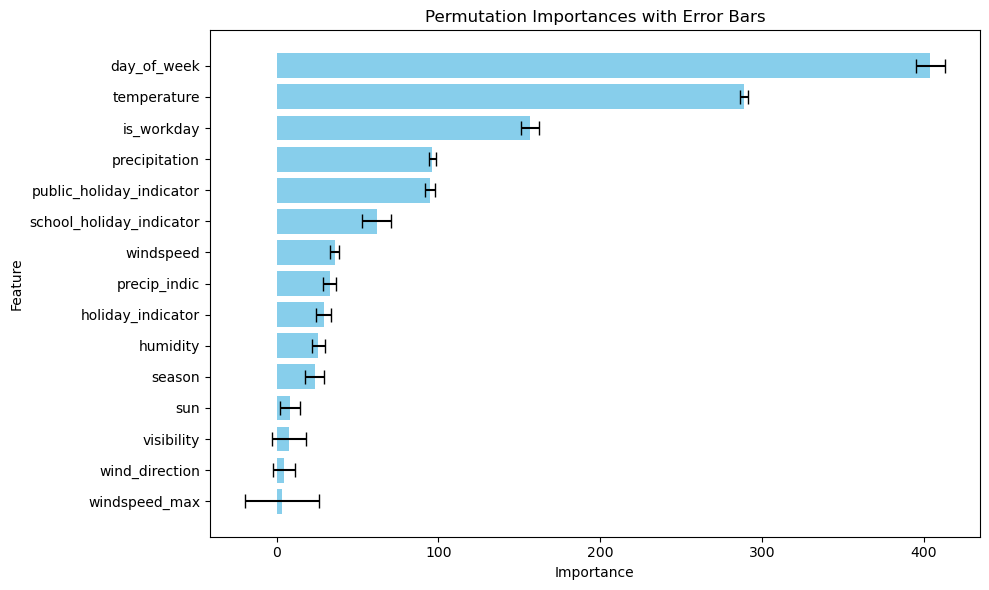

In [ ]:
importance_stds_model11a = result_model11a.importances_std

# Plot with error bars
feature_importance = plt.figure(figsize=(10, 6))
plt.barh( importance_df_model11a['Feature'], importance_df_model11a['Importance'], xerr=importance_stds_model11a, color='skyblue', capsize=5 )
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Permutation Importances with Error Bars')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

feature_importance.figure.savefig(base_path_plots / "permutation_importance_model11a.png")


In [23]:
#permutation importance
result_model9 = permutation_importance(model9, X_test_num, y_test, scoring=crps_scorer)
importances_model9 = result_model9.importances_mean

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1

In [24]:
importances_model9 = result_model9.importances_mean

# Create a DataFrame for better readability
importance_df_model9 = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances_model9
}).sort_values(by='Importance', ascending=False)

print(importance_df_model9)

                     Feature  Importance
14               day_of_week  344.920624
0                temperature  258.890137
12                is_workday  215.393234
5              precipitation   99.963821
10  public_holiday_indicator   94.328339
9   school_holiday_indicator   48.054180
6                        sun   43.643410
2                  windspeed   37.426708
8               precip_indic   32.406471
11         holiday_indicator   27.781452
1                   humidity   25.215246
13                    season   21.623505
7              windspeed_max   13.131079
3             wind_direction    3.138110
4                 visibility   -3.651062


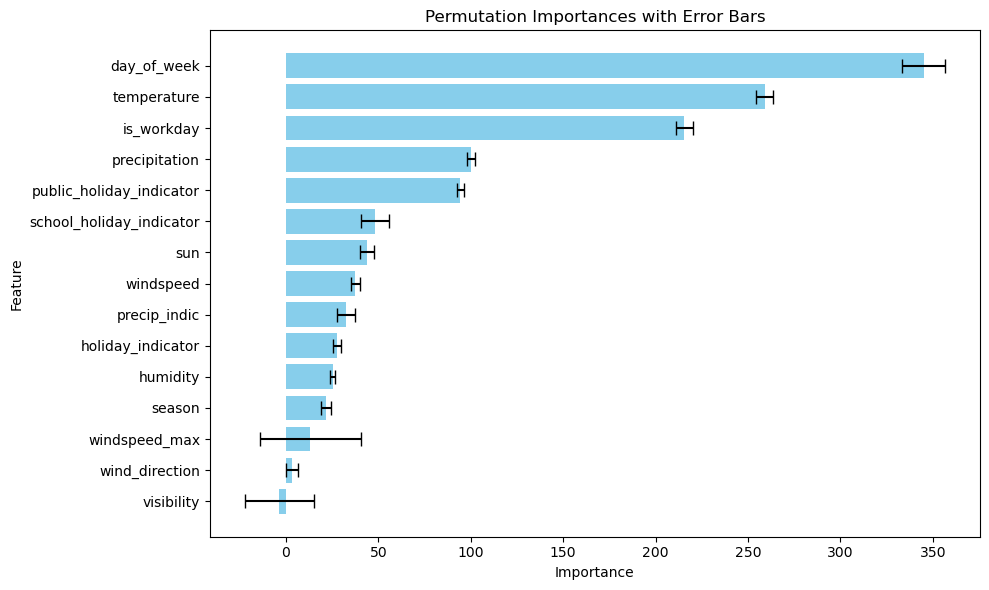

In [ ]:
importance_stds_model9 = result_model9.importances_std

# Plot with error bars
feature_importance = plt.figure(figsize=(10, 6))
plt.barh( importance_df_model9['Feature'], importance_df_model9['Importance'], xerr=importance_stds_model9, color='skyblue', capsize=5 )
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Permutation Importances with Error Bars')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

feature_importance.figure.savefig(base_path_plots / "permutation_importance_model9.png")

# SHAP

In [26]:
# print the JS visualization code to the notebook
shap.initjs()

In [27]:
model45 = build_baseline_model(X_train_num.shape[1])


    Mean CRPS for baseline model with all predictors (except one-hot encoded holiday data): 329.4322340624611
    Columns in baseline model:
    'temperature', 'humidity', 'windspeed', 'wind_direction', 'visibility',
    'precipitation', 'sun', 'windspeed_max', 'precip_indic',
    'school_holiday_indicator', 'public_holiday_indicator',
    'holiday_indicator', 'is_workday', 'season', 'day_of_week'
    


c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
model45, history45 = compile_and_fit_model(model45, X_train_num, y_train, X_valid_num, y_valid, epochs = 200)


Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 200

Epoch 1/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 1846.1825 - val_loss: 500.9354 - learning_rate: 0.0010
Epoch 2/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 800.7823 - val_loss: 532.0634 - learning_rate: 0.0010
Epoch 3/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 773.2217 - val_loss: 535.8582 - learning_rate: 0.0010
Epoch 4/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 709.3605 - val_loss: 466.1864 - learning_rate: 0.0010
Epoch 5/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 658.7693 - val_loss: 490.5479 - learning_rate: 0.0010
Epoch 6/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 657.9610 - val_loss: 512.0656 - learning_rate: 0.0010
Epoch 7/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 613.2122 - val_loss: 473.7727 - learning_rate: 0.0010
Epoch 8/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss

In [29]:
background_data = shap.sample(X_train_num, 100)

In [30]:
explainer_sample = shap.KernelExplainer(model45.predict, background_data)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


In [31]:
shap_values = explainer_sample.shap_values(X_test_num,nsamples=50)

  0%|          | 0/390 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
157/157 ━━━━━━

c:\Users\aisti\anaconda3\Lib\site-packages\sklearn\linear_model\_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.391e+01, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\aisti\anaconda3\Lib\site-packages\sklearn\linear_model\_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=3.686e+00, with an active set of 12 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\aisti\anaconda3\Lib\site-packages\sklearn\linear_model\_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=1.399e+00, with an active set of 14 regressors, and the smallest cholesky pivot el

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━

In [32]:
shap_values_mu = shap_values[:, :, 0]
shap_values_mu_explanation = shap.Explanation(values=shap_values_mu, data=X_test_num)
shap_values_mu_explanation

.values =
array([[ 225.65807899,   97.22837589,  -20.70473577, ..., -312.71353165,
        -255.39397305, -862.5018625 ],
       [ -80.42816602,    0.        ,    0.        , ...,  321.45138913,
        -575.3933424 ,  236.19446847],
       [-517.34881701,    0.        ,    0.        , ...,  350.79647671,
        -822.32089926,  272.29704174],
       ...,
       [-218.06084301,  -24.0595143 , -147.40368577, ...,  286.80917861,
        -212.60559801,  467.76696086],
       [  93.18230182,    0.        , -197.55787862, ...,  277.87813397,
        -151.70047881,  538.69169523],
       [ -80.42011242,   22.92126272,   29.06300895, ...,  357.0038618 ,
        -330.71073893,  436.91897048]])

.data =
     temperature  humidity  windspeed  wind_direction  visibility  \
0       0.156666 -0.574689  -0.146301        0.435186    1.740197   
1      -0.267002  0.406656  -0.196261        0.386631    1.259373   
2      -0.832871  1.040183  -1.011237        0.313798    0.940566   
3      -0.452449  0.

In [33]:
print(shap_values_mu_explanation.feature_names)

None


In [34]:
shap_values_mu_explanation.feature_names = X_train_num.columns.tolist()

In [35]:
type(shap_values_mu_explanation)

shap._explanation.Explanation

In [36]:
shap_values_mu_explanation.shape

(390, 15)

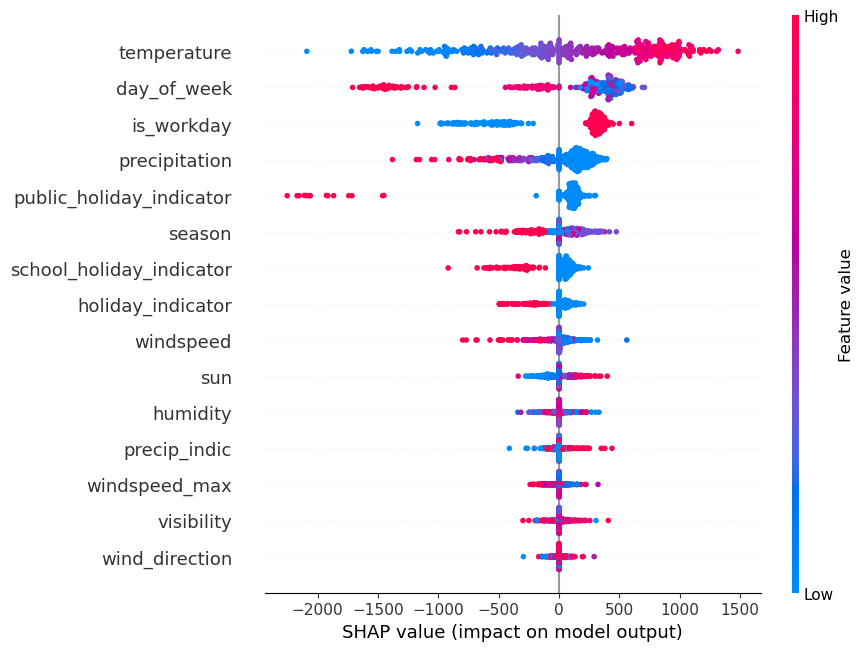

<Figure size 640x480 with 0 Axes>

In [37]:
beeswarm_plot = shap.plots.beeswarm(shap_values_mu_explanation, max_display=15)
plt.tight_layout()
plt.show()
plt.close()

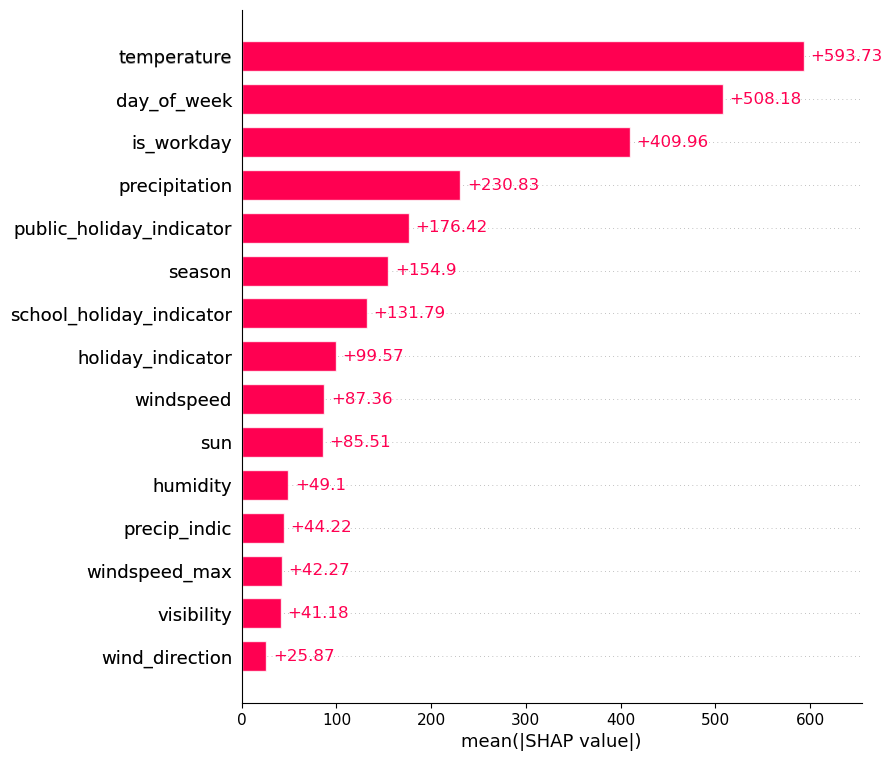

<Figure size 640x480 with 0 Axes>

In [38]:
shap.plots.bar(shap_values_mu_explanation, max_display=15 )
plt.tight_layout()
plt.show()
plt.close()

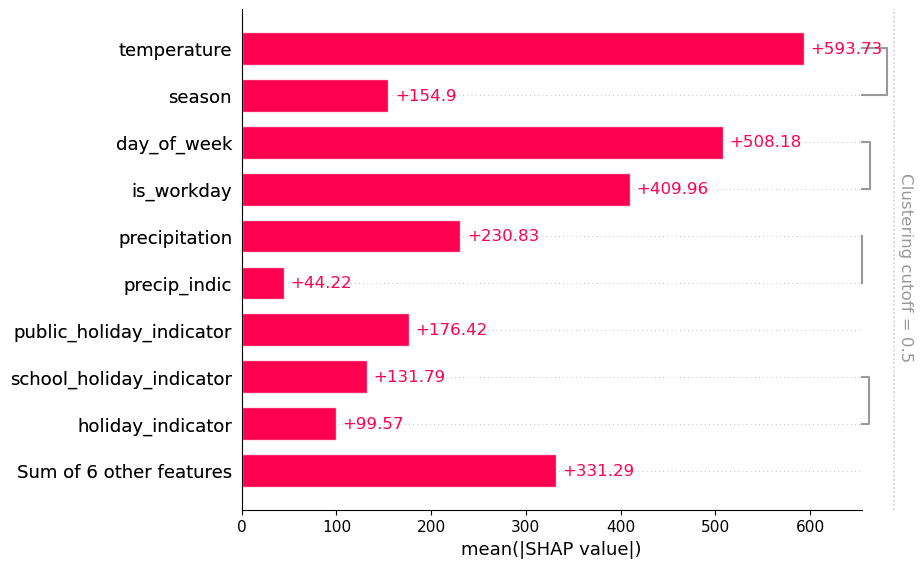

In [39]:
clustering = shap.utils.hclust(X_train_num, y_train)
shap.plots.bar(shap_values_mu_explanation, clustering=clustering)